## Heart Attack Risk Prediction using Deep Learning Techniques

#### The goal is to develop a predictive model using Convalution Neural Networks (CNNs) to identify the likelihood of a heart attack based on ECG Images.

In [1]:
#! pip install wfdb
# !pip install matplotlib pandas

In [2]:
# !pip install wfdb tensorflow opencv-python matplotlib pandas scikit-learn


### Importing libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
import matplotlib.image as mpimg
import random
import warnings
warnings.filterwarnings('ignore')

### Unziping the file

In [4]:
import zipfile

zip_path = "/content/sample_data/ECG_DATA (1).zip"
extract_path = "/content/ECG_DATA(1)"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(" Unzipped ECG_DATA to:", extract_path)


 Unzipped ECG_DATA to: /content/ECG_DATA(1)


### Path for dataset

In [5]:
train_dir = "/content/ECG_DATA(1)/ECG_DATA (1)/train"
test_dir = "/content/ECG_DATA(1)/ECG_DATA (1)/test"

## Count Images per Class

In [6]:
def count_images_in_folder(folder_path):
    class_counts = {}
    for class_name in os.listdir(folder_path):
        class_dir = os.path.join(folder_path, class_name)
        if os.path.isdir(class_dir):
            num_images = len([
                file for file in os.listdir(class_dir)
                if file.lower().endswith(('.png', '.jpg', '.jpeg'))
            ])
            class_counts[class_name] = num_images
    return class_counts

In [7]:
train_counts = count_images_in_folder(train_dir)
test_counts = count_images_in_folder(test_dir)

In [8]:
print("Train Set Image Count:")
for cls, count in train_counts.items():
    print(f"{cls}: {count} images")

print("\nTest Set Image Count:")
for cls, count in test_counts.items():
    print(f"{cls}: {count} images")

Train Set Image Count:
Myocardial Infarction: 956 images
Normal: 852 images
History: 516 images
Abnormal Heartbeat: 699 images

Test Set Image Count:
Myocardial Infarction: 239 images
Normal: 284 images
History: 172 images
Abnormal Heartbeat: 233 images


### Visulization of the plot

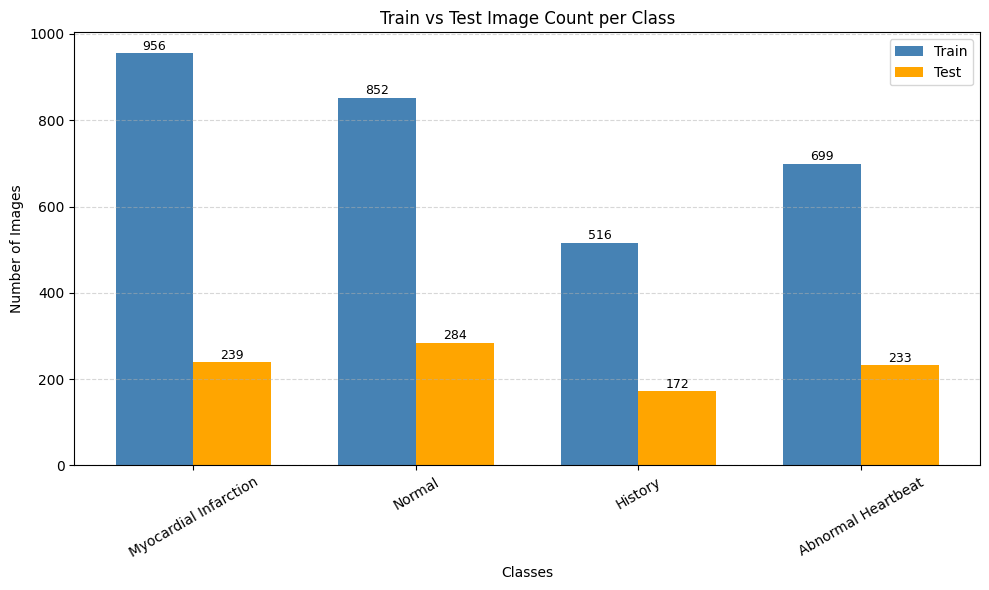

In [9]:
classes = list(train_counts.keys())
x = np.arange(len(classes))

train_values = [train_counts[cls] for cls in classes]
test_values = [test_counts[cls] for cls in classes]

width = 0.35

plt.figure(figsize=(10, 6))
bars1 = plt.bar(x - width/2, train_values, width, label='Train', color='steelblue')
bars2 = plt.bar(x + width/2, test_values, width, label='Test', color='orange')

plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.title("Train vs Test Image Count per Class")
plt.xticks(x,classes)
plt.xticks(rotation=30)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Add values on top of bars
for bar in bars1 + bars2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, yval, ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

### Showing Sample Images from Each Class

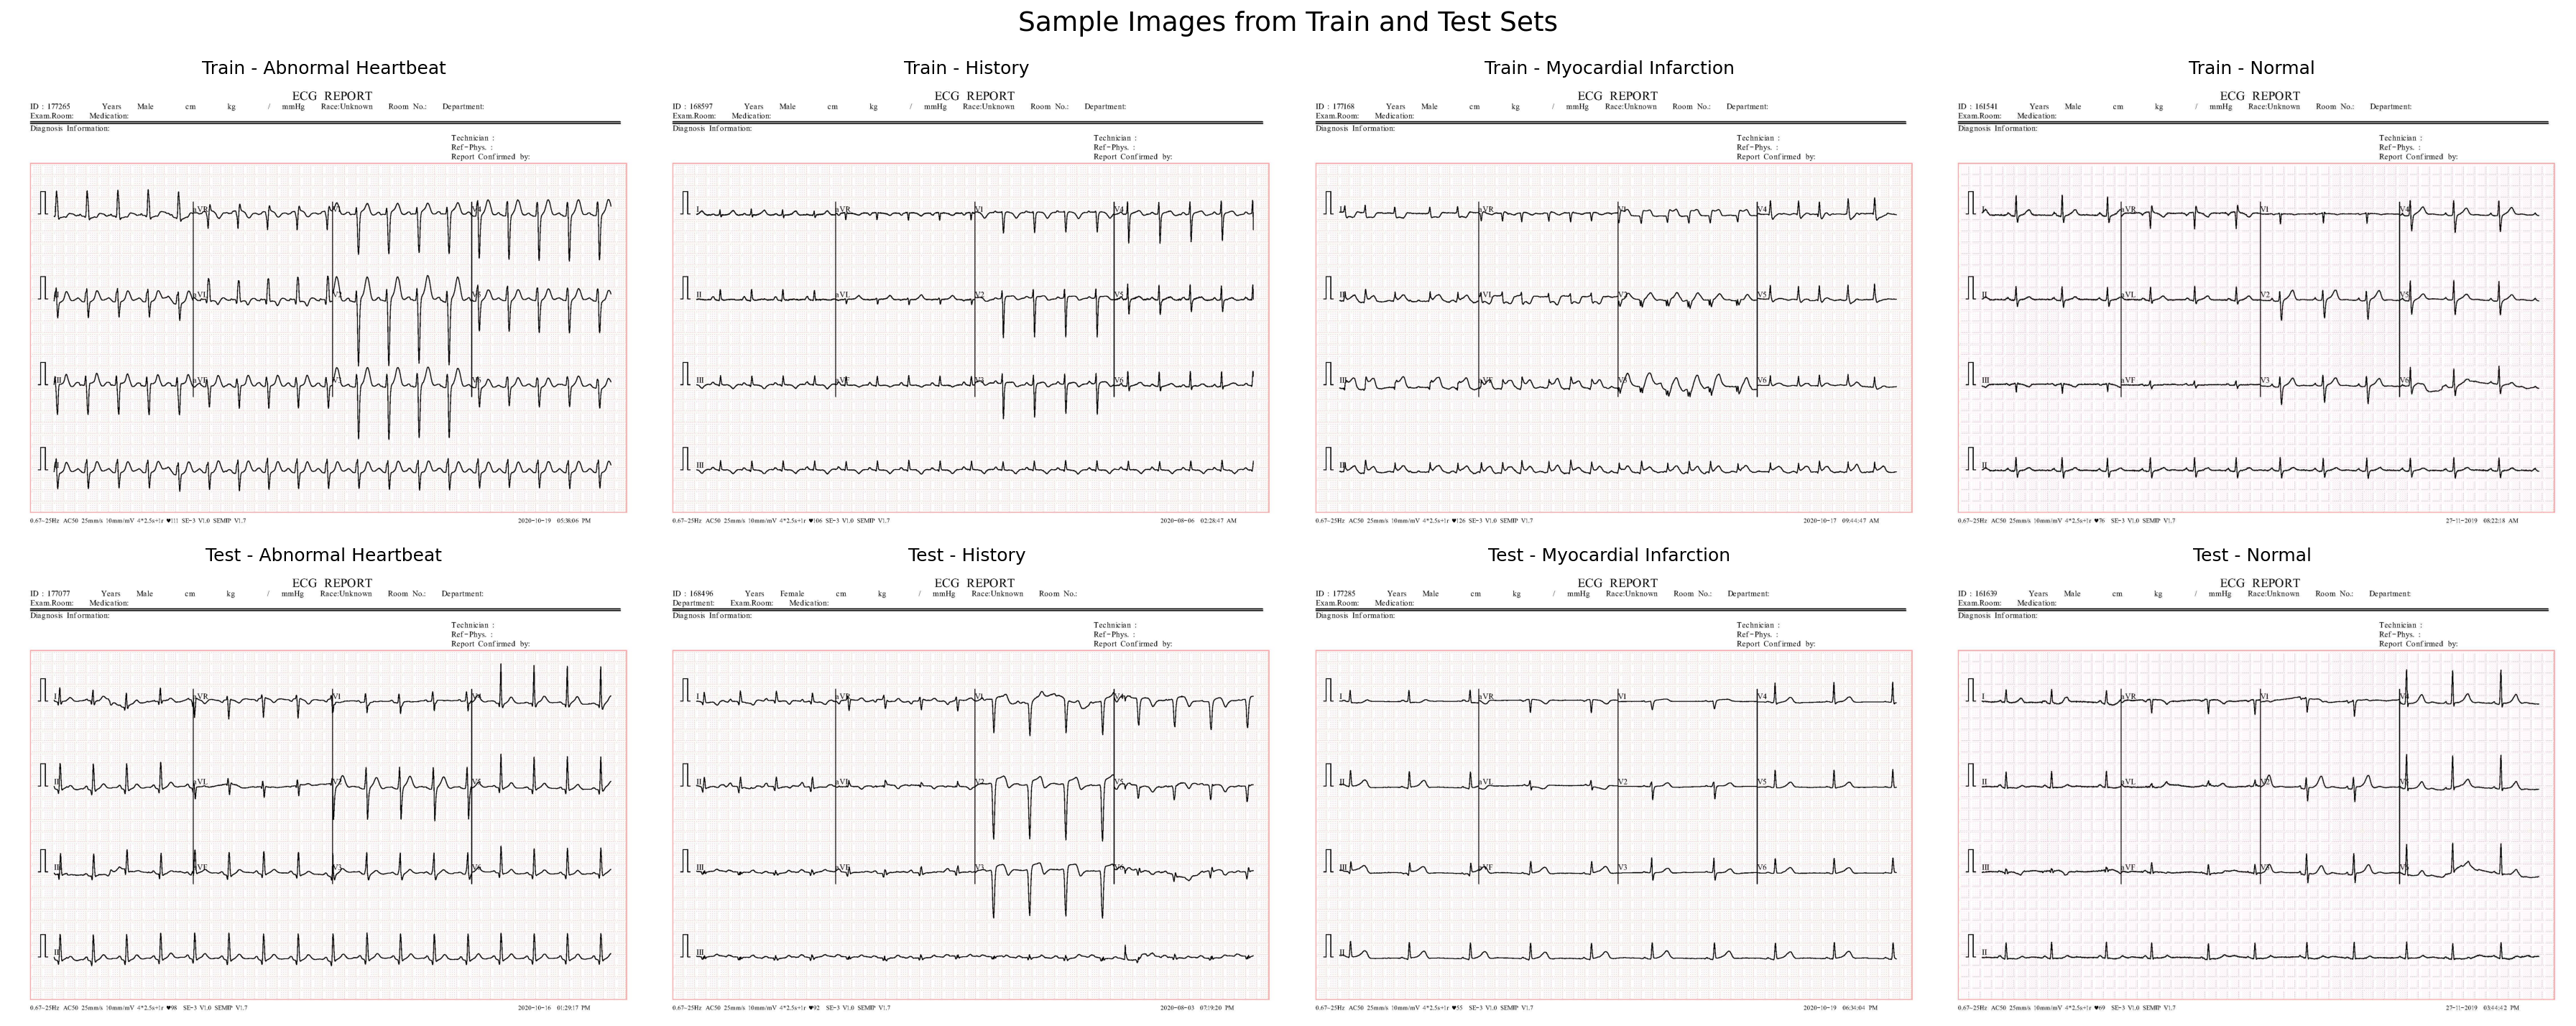

In [10]:
classes = sorted(os.listdir(train_dir))  # assumes same class names in both

plt.figure(figsize=(6 * len(classes), 10), dpi=150)

# Show train images
for i, cls in enumerate(classes):
    class_path = os.path.join(train_dir, cls)
    images = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    if images:
        img_path = os.path.join(class_path, random.choice(images))
        img = Image.open(img_path).convert("RGB")

        plt.subplot(2, len(classes), i + 1)
        plt.imshow(img)
        plt.title(f"Train - {cls}")
        plt.axis('off')

# Show test images
for i, cls in enumerate(classes):
    class_path = os.path.join(test_dir, cls)
    images = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    if images:
        img_path = os.path.join(class_path, random.choice(images))
        img = Image.open(img_path).convert("RGB")

        plt.subplot(2, len(classes), len(classes) + i + 1)
        plt.imshow(img)
        plt.title(f"Test - {cls}")
        plt.axis('off')

plt.suptitle("Sample Images from Train and Test Sets", fontsize=18)
plt.tight_layout()
plt.show()

### Check Image Sizes

In [11]:
# Get image sizes for train
train_shapes = []
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    sample_img_path = os.path.join(class_path, os.listdir(class_path)[0])
    img = Image.open(sample_img_path)
    train_shapes.append((class_name, img.size))

# Get image sizes for test
test_shapes = []
for class_name in os.listdir(test_dir):
    class_path = os.path.join(test_dir, class_name)
    sample_img_path = os.path.join(class_path, os.listdir(class_path)[0])
    img = Image.open(sample_img_path)
    test_shapes.append((class_name, img.size))

# Print results
print("Sample Image Sizes - Train:")
for class_name, shape in train_shapes:
    print(f"  {class_name}: {shape}")

print("\nSample Image Sizes - Test:")
for class_name, shape in test_shapes:
    print(f"  {class_name}: {shape}")

Sample Image Sizes - Train:
  Myocardial Infarction: (2213, 1572)
  Normal: (2213, 1572)
  History: (2213, 1572)
  Abnormal Heartbeat: (2213, 1572)

Sample Image Sizes - Test:
  Myocardial Infarction: (2213, 1572)
  Normal: (2213, 1572)
  History: (2213, 1572)
  Abnormal Heartbeat: (2213, 1572)


### Detect Corrupt Images¶

In [12]:
def find_corrupt_images(folder):
    corrupt = []
    for root, _, files in os.walk(folder):
        for file in files:
            try:
                img_path = os.path.join(root, file)
                img = Image.open(img_path)
                img.verify()
            except:
                corrupt.append(img_path)
    return corrupt

# Check corrupt images
train_corrupt_images = find_corrupt_images(train_dir)
test_corrupt_images = find_corrupt_images(test_dir)

# Print results
print(f"Corrupt Images in Train Folder: {len(train_corrupt_images)}")
for path in train_corrupt_images:
    print("  -", path)

print(f"\nCorrupt Images in Test Folder: {len(test_corrupt_images)}")
for path in test_corrupt_images:
    print("  -", path)

Corrupt Images in Train Folder: 0

Corrupt Images in Test Folder: 0


In [13]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [14]:
img_size = (224, 224)
batch_size = 32

### Initialize Data Generators

In [15]:
train_datagen = ImageDataGenerator(
    #rescale=1./255,
    #rotation_range=10,
    #zoom_range=0.1,
    #width_shift_range=0.1,
    #height_shift_range=0.1,
    #horizontal_flip=True,
    #validation_split=0.2
)
test_datagen = ImageDataGenerator(rescale=1./255)

### Create Data Generators

In [16]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle = True
    #subset='training'
)

test_generator = train_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle = False
    #subset='validation'
)

num_classes = train_generator.num_classes

Found 3023 images belonging to 4 classes.
Found 928 images belonging to 4 classes.


### Define the CNN Architecture

In [17]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(4, activation='softmax')(x)  # 4 classes

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,214,055 (16.08 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

### Train & Compile the Model

In [18]:
early_stop = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint("best_ecg_model.h5", save_best_only=True, monitor='val_accuracy')

In [19]:
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=25,
    callbacks=[early_stop, checkpoint]
)

Epoch 1/25
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 838ms/step - accuracy: 0.2877 - loss: 1.4406

95/95 ━━━━━━━━━━━━━━━━━━━━ 133s 1s/step - accuracy: 0.2880 - loss: 1.4401 - val_accuracy: 0.5377 - val_loss: 1.2576
Epoch 2/25
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 738ms/step - accuracy: 0.4411 - loss: 1.2649

95/95 ━━━━━━━━━━━━━━━━━━━━ 92s 970ms/step - accuracy: 0.4409 - loss: 1.2648 - val_accuracy: 0.5851 - val_loss: 1.1398
Epoch 3/25
95/95 ━━━━━━━━━━━━━━━━━━━━ 89s 933ms/step - accuracy: 0.4741 - loss: 1.2000 - val_accuracy: 0.5797 - val_loss: 1.0646
Epoch 4/25
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 717ms/step - accuracy: 0.5138 - loss: 1.1431

95/95 ━━━━━━━━━━━━━━━━━━━━ 90s 948ms/step - accuracy: 0.5137 - loss: 1.1430 - val_accuracy: 0.6164 - val_loss: 1.0148
Epoch 5/25
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 721ms/step - accuracy: 0.5412 - loss: 1.1130

95/95 ━━━━━━━━━━━━━━━━━━━━ 143s 953ms/step - accuracy: 0.5412 - loss: 1.1127 - val_accuracy: 0.6433 - val_loss: 0.9633
Epoch 6/25
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 719ms/step - accuracy: 0.5497 - loss: 1.0694

95/95 ━━━━━━━━━━━━━━━━━━━━ 90s 947ms/step - accuracy: 0.5499 - loss: 1.0693 - val_accuracy: 0.6670 - val_loss: 0.9262
Epoch 7/25
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 737ms/step - accuracy: 0.5777 - loss: 1.0240

95/95 ━━━━━━━━━━━━━━━━━━━━ 91s 959ms/step - accuracy: 0.5776 - loss: 1.0240 - val_accuracy: 0.7101 - val_loss: 0.9040
Epoch 8/25
95/95 ━━━━━━━━━━━━━━━━━━━━ 140s 936ms/step - accuracy: 0.5649 - loss: 1.0302 - val_accuracy: 0.6950 - val_loss: 0.8729
Epoch 9/25
95/95 ━━━━━━━━━━━━━━━━━━━━ 87s 914ms/step - accuracy: 0.5797 - loss: 0.9933 - val_accuracy: 0.6950 - val_loss: 0.8460
Epoch 10/25
95/95 ━━━━━━━━━━━━━━━━━━━━ 88s 930ms/step - accuracy: 0.6127 - loss: 0.9538 - val_accuracy: 0.7026 - val_loss: 0.8242
Epoch 11/25
95/95 ━━━━━━━━━━━━━━━━━━━━ 89s 936ms/step - accuracy: 0.6130 - loss: 0.9388 - val_accuracy: 0.7080 - val_loss: 0.8121
Epoch 12/25
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 706ms/step - accuracy: 0.6213 - loss: 0.9411

95/95 ━━━━━━━━━━━━━━━━━━━━ 88s 930ms/step - accuracy: 0.6213 - loss: 0.9410 - val_accuracy: 0.7252 - val_loss: 0.8044
Epoch 13/25
95/95 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - accuracy: 0.6345 - loss: 0.9225 - val_accuracy: 0.7220 - val_loss: 0.7818
Epoch 14/25
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 701ms/step - accuracy: 0.6285 - loss: 0.9320

95/95 ━━━━━━━━━━━━━━━━━━━━ 87s 917ms/step - accuracy: 0.6285 - loss: 0.9320 - val_accuracy: 0.7522 - val_loss: 0.7702
Epoch 15/25
95/95 ━━━━━━━━━━━━━━━━━━━━ 88s 932ms/step - accuracy: 0.6417 - loss: 0.9003 - val_accuracy: 0.7252 - val_loss: 0.7542
Epoch 16/25
95/95 ━━━━━━━━━━━━━━━━━━━━ 140s 915ms/step - accuracy: 0.6476 - loss: 0.8900 - val_accuracy: 0.7425 - val_loss: 0.7556
Epoch 17/25
95/95 ━━━━━━━━━━━━━━━━━━━━ 88s 924ms/step - accuracy: 0.6254 - loss: 0.9255 - val_accuracy: 0.7478 - val_loss: 0.7376
Epoch 18/25
95/95 ━━━━━━━━━━━━━━━━━━━━ 88s 932ms/step - accuracy: 0.6403 - loss: 0.8925 - val_accuracy: 0.7414 - val_loss: 0.7232
Epoch 19/25
95/95 ━━━━━━━━━━━━━━━━━━━━ 141s 917ms/step - accuracy: 0.6581 - loss: 0.8517 - val_accuracy: 0.7349 - val_loss: 0.7211


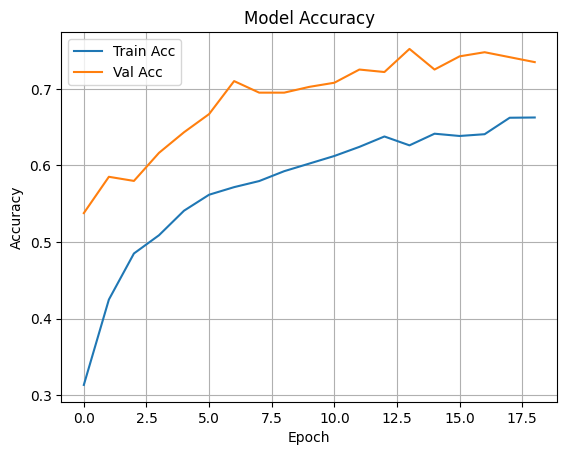

In [20]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [21]:
base_model.trainable = True
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

history_fine = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=15,
    callbacks=[early_stop, checkpoint]
)

Epoch 1/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 208s 1s/step - accuracy: 0.2920 - loss: 1.4574 - val_accuracy: 0.3448 - val_loss: 1.3289
Epoch 2/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 91s 953ms/step - accuracy: 0.5310 - loss: 1.1253 - val_accuracy: 0.3147 - val_loss: 1.3999
Epoch 3/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 92s 965ms/step - accuracy: 0.6772 - loss: 0.8956 - val_accuracy: 0.5797 - val_loss: 1.0784
Epoch 4/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 731ms/step - accuracy: 0.7692 - loss: 0.7300

95/95 ━━━━━━━━━━━━━━━━━━━━ 90s 952ms/step - accuracy: 0.7694 - loss: 0.7296 - val_accuracy: 0.7823 - val_loss: 0.7454
Epoch 5/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 728ms/step - accuracy: 0.8289 - loss: 0.5824

95/95 ━━━━━━━━━━━━━━━━━━━━ 91s 960ms/step - accuracy: 0.8290 - loss: 0.5822 - val_accuracy: 0.8728 - val_loss: 0.4668
Epoch 6/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 752ms/step - accuracy: 0.8748 - loss: 0.4506

95/95 ━━━━━━━━━━━━━━━━━━━━ 94s 996ms/step - accuracy: 0.8748 - loss: 0.4505 - val_accuracy: 0.9181 - val_loss: 0.2961
Epoch 7/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 737ms/step - accuracy: 0.8876 - loss: 0.3911

95/95 ━━━━━━━━━━━━━━━━━━━━ 93s 977ms/step - accuracy: 0.8876 - loss: 0.3910 - val_accuracy: 0.9569 - val_loss: 0.1923
Epoch 8/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 730ms/step - accuracy: 0.9166 - loss: 0.3112

95/95 ━━━━━━━━━━━━━━━━━━━━ 91s 960ms/step - accuracy: 0.9166 - loss: 0.3110 - val_accuracy: 0.9709 - val_loss: 0.1323
Epoch 9/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 732ms/step - accuracy: 0.9296 - loss: 0.2581

95/95 ━━━━━━━━━━━━━━━━━━━━ 91s 959ms/step - accuracy: 0.9296 - loss: 0.2581 - val_accuracy: 0.9828 - val_loss: 0.0949
Epoch 10/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 761ms/step - accuracy: 0.9326 - loss: 0.2273

95/95 ━━━━━━━━━━━━━━━━━━━━ 94s 997ms/step - accuracy: 0.9327 - loss: 0.2272 - val_accuracy: 0.9914 - val_loss: 0.0693
Epoch 11/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 721ms/step - accuracy: 0.9503 - loss: 0.1816

95/95 ━━━━━━━━━━━━━━━━━━━━ 91s 954ms/step - accuracy: 0.9504 - loss: 0.1816 - val_accuracy: 0.9946 - val_loss: 0.0500
Epoch 12/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 735ms/step - accuracy: 0.9506 - loss: 0.1801

95/95 ━━━━━━━━━━━━━━━━━━━━ 112s 1s/step - accuracy: 0.9507 - loss: 0.1799 - val_accuracy: 0.9968 - val_loss: 0.0369
Epoch 13/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 92s 971ms/step - accuracy: 0.9704 - loss: 0.1270 - val_accuracy: 0.9968 - val_loss: 0.0287
Epoch 14/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 721ms/step - accuracy: 0.9702 - loss: 0.1263

95/95 ━━━━━━━━━━━━━━━━━━━━ 90s 953ms/step - accuracy: 0.9702 - loss: 0.1262 - val_accuracy: 0.9978 - val_loss: 0.0211
Epoch 15/15
95/95 ━━━━━━━━━━━━━━━━━━━━ 88s 928ms/step - accuracy: 0.9693 - loss: 0.1219 - val_accuracy: 0.9978 - val_loss: 0.0161


In [22]:
model.save("best_ecg_model_finetuned.h5")

### Plot Training & Validation Accuracy

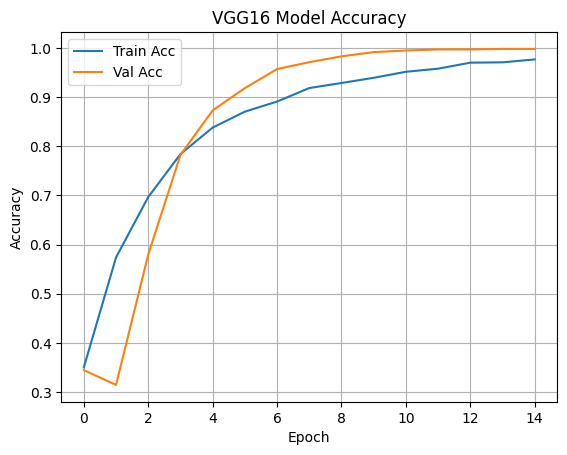

In [23]:
plt.plot(history_fine.history['accuracy'], label='Train Acc')
plt.plot(history_fine.history['val_accuracy'], label='Val Acc')
plt.title('VGG16 Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


### Plot loss & Validation loss

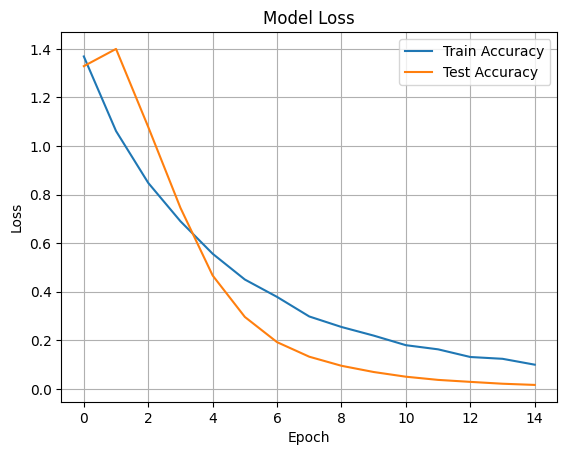

In [24]:
plt.plot(history_fine.history['loss'], label='Train Accuracy')
plt.plot(history_fine.history['val_loss'], label='Test Accuracy')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### Evaluate Model Performance

In [25]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [26]:
# Get predictions from the model
y_pred_probs = model.predict(test_generator, verbose=1)

# Convert predicted probabilities to class indices
y_pred = np.argmax(y_pred_probs, axis=1)

# True labels
y_true = test_generator.classes

# Class names
class_names = list(test_generator.class_indices.keys())

29/29 ━━━━━━━━━━━━━━━━━━━━ 26s 661ms/step


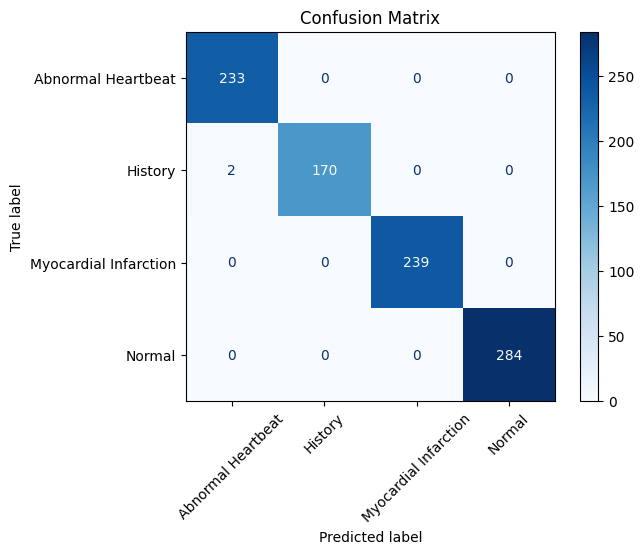

In [27]:
cm = confusion_matrix(y_true, y_pred)

# Plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()


In [28]:
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

Classification Report:
                       precision    recall  f1-score   support

   Abnormal Heartbeat       0.99      1.00      1.00       233
              History       1.00      0.99      0.99       172
Myocardial Infarction       1.00      1.00      1.00       239
               Normal       1.00      1.00      1.00       284

             accuracy                           1.00       928
            macro avg       1.00      1.00      1.00       928
         weighted avg       1.00      1.00      1.00       928

